In [38]:
import torch
import torch.nn as nn
from einops import rearrange, reduce

torch.autograd.set_detect_anomaly(True)

In [30]:
# simple function
def mod_addition(a, b, P):
    return (a + b) % P

def mod_addition_tensor(X, P):
    return mod_addition(X[..., 0], X[..., 1], P)

P = 13
a = 6
b = 11
X1 = torch.tensor([6, 11])
X2 = torch.tensor([[6, 11],
                   [0, 1]])

print(mod_addition(a, b, P))
print(mod_addition_tensor(X1, P))
print(mod_addition_tensor(X2, P))

4
tensor(4)
tensor([4, 1])


In [31]:
# complex algorithm
def mod_addition_alg(a, b, P):
    w = torch.tensor([14, 35, 41, 42, 52])                          # frequencies
    c = rearrange(torch.arange(P), "x -> x 1")                      # potential c values
    cos = torch.cos;    sin = torch.sin                             # to simplify following expression

    terms = (cos(w*a)*cos(w*b) - sin(w*a)*sin(w*b)) * cos(w*c) \
        + (sin(w*a)*cos(w*b) - cos(w*a)*sin(w*b)) * sin(w*c)        # trig terms, expanded out
    logits = reduce(terms, "h w -> h", "sum")                       # sum across the frequencies
    print(logits)

    i_max = torch.argmax(logits).item()
    return c[i_max]

P = 13
a = 6
b = 11

print(mod_addition_alg(a, b, P))

tensor([ 0.3015, -1.6525,  1.2461, -1.7482,  2.8471, -1.9745,  0.6706, -1.3065,
         1.7828, -0.4857, -0.2055, -0.1409, -0.8562])
tensor([4])


In [32]:
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

In [40]:
# Model architecture
# "one-layer ReLU transformer, token embeddings with d = 128, learned positional embeddings, 4 attention heads of dimension d/4 = 32, and n = 512 hidden units in the MLP. In other experiments, we vary the depth and dimension of the model. We did not use LayerNorm or tie our embed/unembed matrices."

class MultiHeadAttention(nn.Module):
    def __init__(self, l_context, d_token, N_heads, d_head):
        super().__init__()
        self.sa_heads = [nn.Linear(d_token, d_head, bias=False) for _ in range(N_heads)]

        # projects from concatenated sa_head outputs to something to add to the residual stream
        self.proj = nn.Linear(N_heads*d_head, d_token) 

    def forward(self, x):
        # might still need to add in positional encoding? (doubt it though)
        x_concat = reduce(
            torch.concat([sa(x) for sa in self.sa_heads], dim=2),
            "b t c -> b c", "sum"
        )
        x_att = self.proj(x_concat)
        
        return x_att


class Block(nn.Module):
    def __init__(self, l_context, d_token, 
                 N_heads, d_head, 
                 d_ffwd):
        super().__init__()
        
        self.sa_heads = MultiHeadAttention(l_context, d_token, N_heads, d_head)

        self.ln1 = nn.LayerNorm(d_token)

        self.ffwd_head = nn.Sequential(
            nn.Linear(d_token, d_ffwd),
            nn.ReLU(),
            nn.Linear(d_ffwd, d_token)
        )

        self.ln2 = nn.LayerNorm(d_token)


    def forward(self, x):
        x = self.ln1(self.sa_heads(x))
        x = x + self.ln2(self.ffwd_head(x))

        return x


class ModAdd(torch.nn.Module):
    def __init__(self, p, 
                 d,
                 N_heads, d_head,
                 d_ffwd, 
                 n):
        """
        model = ModAdd(p, ...)
        c = model(a, b)
        -> c = (a + b) % p
        """

        super().__init__()

        self.d_inout = p                # prime number on the RHS of '%'
        # Residual stream
        self.d_token = d                # embedding dimension of tokens
        self.l_context = 2              # context length
        # Attention heads
        self.N_heads = N_heads          # no. of sa_heads working in parallel
        self.d_head = d_head            # dimension of each sa_head (ie. final dim of K, Q, V arrays)
        # Feed-forward layer (within block)
        self.d_ffwd = d_ffwd

        # Layers
        self.token_embedding_table = nn.Embedding(
            num_embeddings=self.d_inout, 
            embedding_dim=self.d_token
        )
        
        self.block = Block(
            self.l_context, self.d_token, 
            self.N_heads, self.d_head, 
            self.d_ffwd)

        self.linear = nn.Linear(self.d_token, self.d_inout)

        self.cross_entropy = nn.CrossEntropyLoss()
        
    def forward(self, X, Y_target=None):
        x = self.token_embedding_table(X)           # no positional encoding needed
        x_ffwd = self.block(x)
        logits = self.linear(x_ffwd)

        if Y_target is None:
            loss = None
            return logits, loss
        
        B, C = logits.shape
        assert C == self.d_inout
        loss = self.cross_entropy(logits, Y_target)
        
        return logits, loss
    
    def calculate(self, X):
        X = torch.tensor(X)

        if len(X.shape) == 2:
            pass
        elif len(X.shape) == 1:
            # add batch dimension
            X = rearrange(X, "c -> 1 c")
        else:
            raise ValueError(f"X {X.shape} has the wrong number of dimensions")
        
        assert X.shape[1] == 2, "X must be of shape (N, 2)"

        logits = self.forward(X)[0]
        Y_pred = torch.argmax(logits, dim=1)
        return Y_pred


p = 113
model = ModAdd(p=p, d=128, N_heads=4, d_head=32, d_ffwd=128*4, n=512).to(device)

## test data
# X = torch.randint(0, p, [5, 2])
# Y_target = mod_addition_tensor(X, p)

# logits, loss = model(X, Y_target)
# Y_pred = model.calculate(X)
# print(Y_pred)


In [34]:
class ModAdditionBatcher:
    @staticmethod    
    def mod_addition_tensor(X, p):
        return (X[..., 0] + X[..., 1]) % p
    
    def __init__(self, p, frac_train, n_sample_default=None):
        i_shuffled = torch.randperm(p*p)
        
        X_all = torch.zeros([p*p, 2], dtype=int)
        X_all[:, 0] = i_shuffled // p
        X_all[:, 1] = i_shuffled % p
        Y_all = ModAdditionBatcher.mod_addition_tensor(X_all, p)
        
        i_test = int(frac_train * p*p)
        
        self.X_train = X_all[:i_test]
        self.Y_train = Y_all[:i_test]
        self.n_train = len(self.X_train)

        self.X_test = X_all[i_test:]
        self.Y_test = Y_all[i_test:]
        self.n_test = len(self.X_test)

        self.n_sample_default = n_sample_default
    
    def __call__(self, test_train, n_sample=None):
        if test_train == "train":
            X = self.X_train
            Y = self.Y_train
            n_X = self.n_train
        elif test_train == "test":
            X = self.X_test
            Y = self.Y_test
            n_X = self.n_test
        else:
            raise ValueError(f"`test_train` {test_train} is invalid. Can only be 'test' or 'train'")
        
        if n_sample is None:
            n_sample = self.n_sample_default
        
        assert n_sample is not None, "cannot have n_sample and n_sample_default = None"
        assert n_sample <= n_X, f"n_sample = {n_sample} is too large (> {n_X})"
        
        i_shuffled = torch.randperm(n_sample)
        return X[i_shuffled], Y[i_shuffled]

batcher = ModAdditionBatcher(p=p, frac_train=0.3, n_sample_default=int(0.05*131*131))


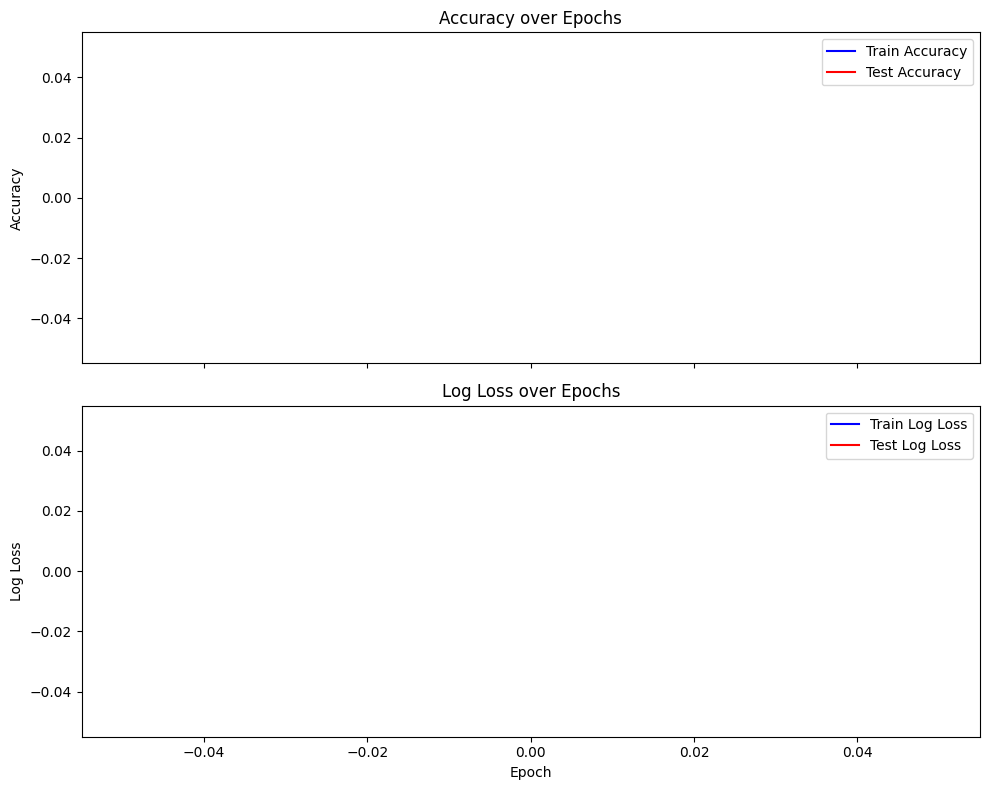

epoch_i=0, loss: 1.6199650417547673e-05
epoch_i=5, loss: 0.0037460371386259794
epoch_i=10, loss: 0.0033336938358843327
epoch_i=15, loss: 0.0011574937961995602
epoch_i=20, loss: 0.0006516138673759997
epoch_i=25, loss: 0.00045131068327464163
epoch_i=30, loss: 0.00025484818615950644
epoch_i=35, loss: 0.00015525791968684644
epoch_i=40, loss: 0.00010682931315386668
epoch_i=45, loss: 7.973484753165394e-05
epoch_i=50, loss: 6.254918116610497e-05
epoch_i=55, loss: 5.108510231366381e-05
epoch_i=60, loss: 4.32373744843062e-05
epoch_i=65, loss: 3.771238334593363e-05
epoch_i=70, loss: 3.367859608260915e-05
epoch_i=75, loss: 3.062532778130844e-05
epoch_i=80, loss: 2.8232572731212713e-05
epoch_i=85, loss: 2.6295772840967402e-05
epoch_i=90, loss: 2.4677230612724088e-05
epoch_i=95, loss: 2.3301558030652814e-05
epoch_i=100, loss: 2.2109768906375393e-05
epoch_i=105, loss: 2.1062249288661405e-05
epoch_i=110, loss: 2.0128734831814654e-05
epoch_i=115, loss: 1.928818892338313e-05
epoch_i=120, loss: 1.851775

ValueError: too many values to unpack (expected 3)

In [44]:
import os
import matplotlib.pyplot as plt

def plot_train_test_metrics(acc_train_history, acc_test_history, loss_train_history, loss_test_history):
    plt.ion()
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    acc_train_line, = ax1.plot([], [], color='blue', label='Train Accuracy')
    acc_test_line, = ax1.plot([], [], color='red', label='Test Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.set_title('Accuracy over Epochs')

    loss_train_line, = ax2.plot([], [], color='blue', label='Train Log Loss')
    loss_test_line, = ax2.plot([], [], color='red', label='Test Log Loss')
    ax2.set_ylabel('Log Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    ax2.set_title('Log Loss over Epochs')

    plt.tight_layout()
    plt.show()
    return fig, (ax1, ax2), (acc_train_line, acc_test_line, loss_train_line, loss_test_line)

def update_plot(acc_train_history, acc_test_history, loss_train_history, loss_test_history, lines):
    acc_train_line, acc_test_line, loss_train_line, loss_test_line = lines
    acc_train_line.set_data(range(len(acc_train_history)), acc_train_history)
    acc_test_line.set_data(range(len(acc_test_history)), acc_test_history)
    loss_train_line.set_data(range(len(loss_train_history)), loss_train_history)
    loss_test_line.set_data(range(len(loss_test_history)), loss_test_history)
    for ax in [acc_train_line.axes, loss_train_line.axes]:
        ax.relim()
        ax.autoscale_view()
    plt.pause(0.01)

def train_model(
        model, optimiser, 
        N_epochs, eval_step, 
        batcher,
        ):
    model.train()
    loss_history = torch.zeros([N_epochs])
    acc_train_history = []
    acc_test_history = []
    loss_train_history = []
    loss_test_history = []

    fig, axes, lines = plot_train_test_metrics(acc_train_history, acc_test_history, loss_train_history, loss_test_history)

    for epoch_i in range(N_epochs):
        try:
            X_train, y_train = batcher("train")
            logits_train, loss_train = model(X_train, y_train)
            loss_history[epoch_i] = loss_train
            optimiser.zero_grad()
            loss_train.backward()
            optimiser.step()

            # Accuracy for training
            y_pred_train = torch.argmax(logits_train, dim=1)
            acc_train = (y_pred_train == y_train).float().mean().item()
            acc_train_history.append(acc_train)
            loss_train_history.append(loss_train.item())

            # Accuracy for test
            X_test, y_test = batcher("test")
            model.eval()
            with torch.no_grad():
                logits_test, loss_test = model(X_test, y_test)
                y_pred_test = torch.argmax(logits_test, dim=1)
                acc_test = (y_pred_test == y_test).float().mean().item()
                acc_test_history.append(acc_test)
                loss_test_history.append(loss_test.item())
            model.train()

            update_plot(acc_train_history, acc_test_history, loss_train_history, loss_test_history, lines)

            if not (epoch_i % eval_step):   # once every `eval_step` epochs
                if not epoch_i:             # if epoch_i == 0
                    loss_mean = loss_train
                else:
                    loss_mean = loss_history[epoch_i-eval_step + 1:epoch_i + 1].mean()
                print(f"{epoch_i=}, loss: {loss_mean}")
        except KeyboardInterrupt:
            break

    plt.ioff()
    plt.show()

    # Output history data
    return model, loss_history, loss_mean, acc_train_history, acc_test_history, loss_train_history, loss_test_history

# def train_model(
#         model, optimiser, 
#         N_epochs, eval_step, 
#         batcher,
#         ):
#     model.train()
#     loss_history = torch.zeros([N_epochs])

#     for epoch_i in range(N_epochs):
#         try:
#             X_train, y_train = batcher("train")
#             _, loss = model(X_train, y_train)
#             loss_history[epoch_i] = loss
#             optimiser.zero_grad()
#             loss.backward()
#             optimiser.step()

#             if not (epoch_i % eval_step):   # once every `eval_step` epochs
#                 if not epoch_i:             # if epoch_i == 0
#                     loss_mean = loss
#                 else:
#                     loss_mean = loss_history[epoch_i-eval_step + 1:epoch_i + 1].mean()
#                 print(f"{epoch_i=}, loss: {loss_mean}")
#         except KeyboardInterrupt:
#             break
    
#     return model, loss_history, loss_mean


def save_model(model, final_loss, parent_path):
    os.makedirs(f"{parent_path}/models", exist_ok=True)
    fname = f"{parent_path}/models/gpt_loss={final_loss:.2f}"
    torch.save(model.state_dict(), fname)
    print(f"model saved to `{fname}`")


N_EPOCHS = 200
eval_step = 5
LR = 1e-3
optimiser = torch.optim.AdamW(model.parameters(), lr=LR)
parent_path = "ModAdditionGrokking"

model, loss_history, final_loss = train_model(
    model, optimiser, 
    N_EPOCHS, eval_step, 
    batcher,
)

save_model(model, final_loss, parent_path)

In [ ]:
"""
Changes:
- redo self-attention
    -> no need for 'attention' part of transformer? (since position isn't important)
       (maybe make it easy to turn on and off or at least have a think about it)
    -> actually gonna be simpler because there's only ever one new token and it has (a,b) as context (no need for tril mumbo jumbo)
- simplify the loss calculation
    -> the output is a (..., 1) vector (ie. c), so that might make it a bit simpler...? (not really, but just need to implement)
- sample the logits (just argmax for accuracy)

TODO:
- train it
- look at Nander's library
"""

In [ ]:
# x = torch.randn(4, 3)
# wei = torch.tril(torch.ones(3, 3))
# wei /= reduce(wei, "i j -> j 1", "sum")
# print(wei)
# xbow = wei @ x

tensor([[0.3333, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [1.0000, 1.0000, 1.0000]])


In [ ]:
# Data
# 30% training, 70% test

In [ ]:
# Training
# full-batch gradient descent
# AdamW optimiser
# learning rage = 0.001, 
# N_epochs = 40_000